#### Libary imports

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from IPython.display import Markdown, display
pd.set_option('display.max_row', 200) # Set ipython's max row display
pd.set_option('display.max_columns', 85) # Set iPython's max column count
pd.set_option('display.max_colwidth', 1_000) # Set iPython's max column width

# pseudo-markdown in code cells
def printmd(string):
    display(Markdown(string))
# ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552/2

#### Dataset 1: "New" flavor, pulled from Reddit on 10/13/20

In [4]:
# Read in the data
subred = pd.read_csv('../data/df_with_both_subs.csv')

# Keep the columns simple
subred = subred[['title', 'subreddit']]

display(pd.set_option('display.max_colwidth', 50), subred.head())

None

,title,subreddit
0,What would the point be to do anything if AI c...,futurology
1,ELCC Explained: the Critical Renewable Energy ...,futurology
2,There's a 50-50 chance we're living in a simul...,futurology
3,"Eight nations sign NASA's Artemis Accords, ple...",futurology
4,Mercedes benz AVTR - In Action,futurology


In [13]:
# Format the title as a list of strings
corpus = list(subred['title'])

# Instantiate SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Preview polarity scores for the first subreddit post
display(corpus[:1], sia.polarity_scores(corpus[0]))

In [27]:
# Create a dataframe with polarity scores, subreddit title and subreddit

subred_with_sentiment_list = []

for post in corpus:
    scores = sia.polarity_scores(post)
    scores['title'] = post
    subred_with_sentiment_list.append(scores)
    
subred_with_sentiment_df = pd.DataFrame(subred_with_sentiment_list) 
subred_with_sentiment_df['subreddit'] = subred['subreddit']
subred_with_sentiment_df.head()

,neg,neu,pos,compound,title,subreddit
0,0.000,1.000,0.000,0.0000,What would the point be to do anything if AI c...,futurology
1,0.047,0.883,0.070,0.0258,ELCC Explained: the Critical Renewable Energy ...,futurology
2,0.000,0.802,0.198,0.6597,There's a 50-50 chance we're living in a simul...,futurology
3,0.000,0.837,0.163,0.5423,"Eight nations sign NASA's Artemis Accords, ple...",futurology
4,0.000,1.000,0.000,0.0000,Mercedes benz AVTR - In Action,futurology


## EDA

### Check out the polarities

In [117]:
printmd('**Overall most positive (according to VADER)**')
display(pd.set_option('display.max_colwidth', 80), subred_with_sentiment_df.sort_values(by = 'pos', ascending = False)[:10])

printmd('**Overall most negative  (according to VADER)**')
display(pd.set_option('display.max_colwidth', 80), subred_with_sentiment_df.sort_values(by = 'neg', ascending = False)[:10])

**Overall most positive (according to VADER)**

None

,neg,neu,pos,compound,title,subreddit
459,0.0,0.244,0.756,0.4767,Artificial Intelligence,futurology
44,0.0,0.391,0.609,0.7378,Electric Flying Cars Get SAFETY Boost 🚀,futurology
995,0.0,0.483,0.517,0.8244,"""Slow Blinking"" really does help convince cats that you want to be friends",science
147,0.0,0.485,0.515,0.6486,Tiny ingestible capsule helps treat gastrointestinal disorders.,futurology
1587,0.0,0.508,0.492,0.7003,Plants sense temperature with help of elegant protein,science
1359,0.0,0.517,0.483,0.6808,Mechanically robust lattices inspired by deep-sea glass sponges,science
118,0.0,0.519,0.481,0.5719,Graphene microbubbles make perfect lenses,futurology
166,0.0,0.533,0.467,0.7906,What will happen in the world of Artificial Super Intelligence?,futurology
558,0.0,0.533,0.467,0.7845,Singapore to treat infosec as equivalent public good to fresh running water,futurology
432,0.0,0.534,0.466,0.7178,Will advanced robotics take our jobs or create more opportunities? (Research),futurology


**Overall most negative  (according to VADER)**

None

,neg,neu,pos,compound,title,subreddit
484,0.661,0.339,0.000,-0.5994,Politics and war,futurology
789,0.655,0.345,0.000,-0.5859,Varieties of Bullshit,futurology
1618,0.571,0.429,0.000,-0.8402,Scientists Spot Giant Planet Orbiting Dead Star's Corpse,science
94,0.557,0.443,0.000,-0.8316,U.K. Risks Losing Its Most Robot-Proof Jobs to Covid Crisis,futurology
919,0.500,0.500,0.000,-0.2500,Pandemic of hunger,science
1447,0.487,0.513,0.000,-0.4215,Prediction errors bidirectionally bias time perception,science
359,0.484,0.220,0.297,-0.4019,A promising breath-test for cancer,futurology
83,0.457,0.543,0.000,-0.6369,were humans doomed from the start?,futurology
1489,0.444,0.556,0.000,-0.7351,"Contradicting Previous Theories, Neuroscientists Find Overlap Between Fear a...",science
1098,0.442,0.558,0.000,-0.8271,"Stark racial bias revealed in police killings of older, mentally ill, unarme...",science


In [118]:
printmd('**Most positive posts in `science` only (according to VADER)**')
display(pd.set_option('display.max_colwidth', 80), subred_with_sentiment_df[subred_with_sentiment_df['subreddit'] == 'science'].sort_values(by = 'pos', ascending = False)[:10])

printmd('**Most negative posts in `science` only (according to VADER)**')
display(pd.set_option('display.max_colwidth', 80), subred_with_sentiment_df[subred_with_sentiment_df['subreddit'] == 'science'].sort_values(by = 'neg', ascending = False)[:10])


**Most positive posts in `science` only (according to VADER)**

None

,neg,neu,pos,compound,title,subreddit
995,0.000,0.483,0.517,0.8244,"""Slow Blinking"" really does help convince cats that you want to be friends",science
1587,0.000,0.508,0.492,0.7003,Plants sense temperature with help of elegant protein,science
1359,0.000,0.517,0.483,0.6808,Mechanically robust lattices inspired by deep-sea glass sponges,science
1393,0.000,0.559,0.441,0.7430,Reversible dynamics with closed time-like curves and freedom of choice,science
1043,0.094,0.470,0.436,0.7269,A strong no-go theorem on the Wigner’s friend paradox | Nature Physics,science
1748,0.000,0.568,0.432,0.7645,The most important predictors of support for climate policy in the United St...,science
1002,0.000,0.611,0.389,0.6249,New psychology study suggests intellectual humility has important sociopolit...,science
1424,0.000,0.622,0.378,0.7845,Mindful meditation can help subjects learn and improve the ability to mind-c...,science
1517,0.192,0.436,0.373,0.8873,Moral Choice When Harming Is Unavoidable. When people can completely avoid c...,science
1208,0.163,0.466,0.370,0.7964,"From San Diego to Italy, Study Suggests Wisdom can Protect Against Lonelines...",science


**Most negative posts in `science` only (according to VADER)**

None

,neg,neu,pos,compound,title,subreddit
1618,0.571,0.429,0.000,-0.8402,Scientists Spot Giant Planet Orbiting Dead Star's Corpse,science
919,0.500,0.500,0.000,-0.2500,Pandemic of hunger,science
1447,0.487,0.513,0.000,-0.4215,Prediction errors bidirectionally bias time perception,science
1489,0.444,0.556,0.000,-0.7351,"Contradicting Previous Theories, Neuroscientists Find Overlap Between Fear a...",science
1098,0.442,0.558,0.000,-0.8271,"Stark racial bias revealed in police killings of older, mentally ill, unarme...",science
1139,0.438,0.476,0.086,-0.8126,New study finds significant association between traumatic brain injury and p...,science
1457,0.431,0.569,0.000,-0.8779,​NTU Singapore scientists devise 'Trojan horse' approach to kill cancer cell...,science
1720,0.403,0.597,0.000,-0.6597,Smartphones can Predict Brain Function Associated with Anxiety and Depression,science
1226,0.395,0.605,0.000,-0.9197,ADHD linked to more financial distress and a fourfold higher risk of suicide...,science
1012,0.394,0.606,0.000,-0.3818,Autoimmune-like responses in severe COVID-19,science


In [113]:
subred_with_sentiment_summary_df = subred_with_sentiment_df.groupby('subreddit').mean()[['pos', 'neg', 'neu', 'compound']]
subred_with_sentiment_summary_df

,pos,neg,neu,compound
subreddit,,,,
futurology,0.084525,0.043749,0.871716,0.109697
science,0.082477,0.063140,0.854380,0.065677


<Figure size 432x288 with 0 Axes>

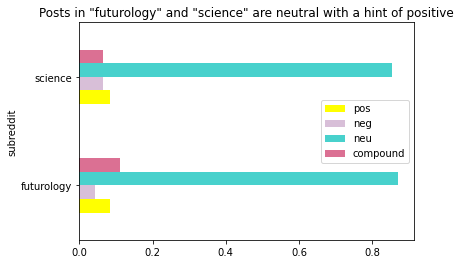

In [123]:
fig = plt.figure()

subred_with_sentiment_summary_df.plot(kind = 'barh', color = ['yellow', 'thistle', 'mediumturquoise', 'palevioletred'])
plt.title('Posts in "futurology" and "science" are neutral with a hint of positive', size = 12)

fig.savefig('temp.png', transparent=True)

# ref: http://jonathansoma.com/lede/data-studio/matplotlib/changing-the-background-of-a-pandas-matplotlib-graph/
# ref: https://benalexkeen.com/bar-charts-in-matplotlib/

In [142]:
subred_with_sentiment_summary_df

,pos,neg,neu,compound
subreddit,,,,
futurology,0.084525,0.043749,0.871716,0.109697
science,0.082477,0.063140,0.854380,0.065677


In [ ]:
# Specify facecolor when creating the figure
fig, ax = plt.subplots(facecolor='seashell')
subred_with_sentiment_summary_df.plot(kind='bar', x='GDP_per_capita', y='life_expectancy', ax=ax, color='white', linewidth=0)

# Specify background color for the axis/plot
ax.set_axis_bgcolor("lightslategray")
ax.set_clip_on(False)

# Be sure to specify facecolor or it won't look right in Illustrator
fig.savefig("output.pdf", facecolor=fig.get_facecolor(), transparent=True)

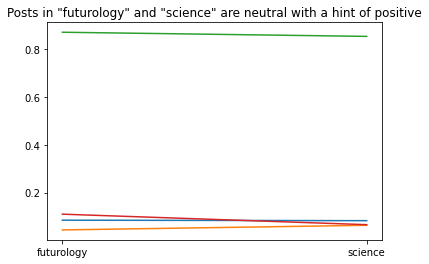

In [141]:
fig = plt.figure()
ax = plt.subplot()

# plt.bar(

plt.plot(subred_with_sentiment_summary_df) # color = ['yellow', 'thistle', 'mediumturquoise', 'palevioletred'])
plt.title('Posts in "futurology" and "science" are neutral with a hint of positive', size = 12)
ax.set_facecolor('seashell')
fig.savefig('temp.png', facecolor = 'seashell')

In [57]:
subred_with_sentiment_df.hist('subreddit', ['pos', 'neg', 'compound'])
plt.xticks(np.arange(-.8, .8, .1))

([<matplotlib.axis.XTick at 0x27742ce5d90>,
 <a list of 16 Text major ticklabel objects>)

Error in callback <function flush_figures at 0x00000277178770D0> (for post_execute):


KeyboardInterrupt: 